# **Deconvolution of LUSC Visium V2 data**

started: 05/03/2025 author: Agathe Sobkowicz

**DEPRECATED** used to test main scrpit: deconv_lusc_v2.py


## Imports & initialisation


In [5]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

import celltypist as ct
import cell2location as cell2loc

from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42  # enables correct plotting of text for PDFs

import data_analysis_functions as da
from cell2location.plt import plot_spatial
import argparse

In [2]:
current_dir = os.getcwd()
parrent_dir = os.path.dirname(current_dir)

In [3]:
# Create paths to results folders for reference signatures and cell2location map
results_dir = os.path.join(current_dir, "results/cell_type_deconv/")
ref_results_dir = os.path.join(results_dir, "reference_signatures")

## Visium data


In [4]:
vis_data_dir = os.path.join(parrent_dir, "LUSC_v2")
slides_list = os.listdir(vis_data_dir)
slides_list

['18P06762',
 '18P08140',
 '17P04394',
 '17P02529',
 '18P06593',
 '18P03122',
 '18P02831']

In [14]:
# Create names for paths to visium data
vis_data_dir = os.path.join(parrent_dir, "LUSC_v2")
slides_list = os.listdir(vis_data_dir)
slide = slides_list[0]
vis_slide_dir = os.path.join(vis_data_dir, slide)

In [8]:
slide_results_dir = os.path.join(results_dir, slide)
os.makedirs(slide_results_dir, exist_ok=True)

st_prepro_results_dir = os.path.join(slide_results_dir, "spatial_preprocessing")
os.makedirs(st_prepro_results_dir, exist_ok=True)

map_results_dir = os.path.join(slide_results_dir, "cell2location_map")
os.makedirs(map_results_dir, exist_ok=True)

In [7]:
# Read spatial transcriptomic (ST) data and modify sample and obs names
adata_vis = sc.read_visium(vis_slide_dir)
# Add column to obs with sample name
adata_vis.obs["sample"] = list(adata_vis.uns["spatial"].keys())[0]
# For deconvolution gene/var names are replaced by ENSEMBL ID to match sc data so no need to make var unique except for preprocessing steps
adata_vis.var["SYMBOL"] = adata_vis.var_names
adata_vis.var_names_make_unique()
if adata_vis.obsm["spatial"].dtype == "object":
    adata_vis.obsm["spatial"] = np.array(adata_vis.obsm["spatial"], dtype=float)

In [9]:
# Import and preprocess data
adata_vis = da.st_processing(adata_vis, slide, st_prepro_results_dir)

Gene outlier
False    13776
True      4309
Name: count, dtype: int64


... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Cell outlier
False    4924
True        1
Name: count, dtype: int64


📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/agathes/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Immune_All_High.pkl
🔬 Input data has 4924 cells and 13776 genes
🔗 Matching reference genes in the model
🧬 4623 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [ ]:
# Rename genes to ENSEMBL ID for correct matching between single cell and spatial data
adata_vis.var.set_index("gene_ids", drop=True, inplace=True)

In [ ]:
# Remove MT genes in ST data because it represents aretefacts in sc data
adata_vis.var["MT_gene"] = [gene.startswith("MT-") for gene in adata_vis.var["SYMBOL"]]
adata_vis.obsm["MT"] = adata_vis[
    :, adata_vis.var["MT_gene"].values
].X.toarray()  # Keep MT counts in obsm
adata_vis = adata_vis[:, ~adata_vis.var["MT_gene"].values]

## Reference single cell data preprocessing


In [ ]:
# Read single cell referemce data
adata_ref = sc.read_h5ad("/home/agathes/work/Sc_data/Sc_cellxgene.h5ad")

In [ ]:
adata_ref.obs

,nCount_RNA,nFeature_RNA,harm_study,harm_healthy.tissue,harm_tumor.site,harm_sample.type,harm_condition,harm_tumor.type,harm_cd45pos,harm_healthy.pat,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
BT1299_GTACTCCTCGGAAACG-1-17,8724,2676,Qian et al,no,primary,tumor,lung_T,lung,no,no,...,tissue,endothelial cell,10x 3' v2,lung cancer,Homo sapiens,male,lung,unknown,seventh decade stage,VQ)lMX+9e2
BT1299_GTACTTTAGCAGGCTA-1-17,2650,1022,Qian et al,no,primary,tumor,lung_T,lung,no,no,...,tissue,mononuclear phagocyte,10x 3' v2,lung cancer,Homo sapiens,male,lung,unknown,seventh decade stage,*C(!*!?gbg
BT1299_GTACTTTAGCATGGCA-1-17,3725,1574,Qian et al,no,primary,tumor,lung_T,lung,no,no,...,tissue,endothelial cell,10x 3' v2,lung cancer,Homo sapiens,male,lung,unknown,seventh decade stage,0Yi2m7iJFf
BT1299_GTACTTTAGGATGTAT-1-17,1436,701,Qian et al,no,primary,tumor,lung_T,lung,no,no,...,tissue,B cell,10x 3' v2,lung cancer,Homo sapiens,male,lung,unknown,seventh decade stage,P;RzB7(bPD
BT1299_GTACTTTAGGCTCTTA-1-17,19715,4427,Qian et al,no,primary,tumor,lung_T,lung,no,no,...,tissue,malignant cell,10x 3' v2,lung cancer,Homo sapiens,male,lung,unknown,seventh decade stage,ucf$;<UYzu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P3_6_GTGCAGCTCATGTCCC-1-3,10662,2905,HLCA,yes,normal,normal,lung_N,lung,mixed,no,...,tissue,epithelial cell,10x 3' v2,normal,Homo sapiens,female,lung,unknown,51-year-old stage,;1iy^qzS4a
P3_6_GTTCGGGTCGGATGGA-1-3,4301,1823,HLCA,yes,normal,normal,lung_N,lung,mixed,no,...,tissue,epithelial cell,10x 3' v2,normal,Homo sapiens,female,lung,unknown,51-year-old stage,es>~!lzqQs
P3_6_TAAGCGTTCAATCACG-1-3,4656,1852,HLCA,yes,normal,normal,lung_N,lung,mixed,no,...,tissue,epithelial cell,10x 3' v2,normal,Homo sapiens,female,lung,unknown,51-year-old stage,X&8axAv1xx
P3_6_TACTTACGTTGATTGC-1-3,5928,2009,HLCA,yes,normal,normal,lung_N,lung,mixed,no,...,tissue,epithelial cell,10x 3' v2,normal,Homo sapiens,female,lung,unknown,51-year-old stage,CQuxrS|j*6


In [ ]:
adata_ref = da.sc_preprocessing(adata_ref)

In [ ]:
adata_ref

AnnData object with n_obs × n_vars = 144432 × 32843
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'sample_cell_type', 'n_genes_by_coun

In [ ]:
adata_ref[~(adata_ref.obs["donor_id"].str.contains("LUAD", na=False))]

View of AnnData object with n_obs × n_vars = 572 × 32843
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'sample_cell_type', 'n_genes_by

In [ ]:
adata_ref.obs["donor_id"][
    ~(adata_ref.obs["donor_id"].str.contains("LUAD", na=False))
].unique()

['Nieto_P1']
Categories (19, object): ['HLCALUAD_1', 'HLCALUAD_2', 'HLCALUAD_3', 'Nieto_P1', ..., 'ZilionisLUAD_p4', 'ZilionisLUAD_p5', 'ZilionisLUAD_p6', 'ZilionisLUAD_p7']

In [ ]:
adata_ref.obs["donor_id"].unique()

['QianLUAD_LC_5', 'QianLUAD_LC_3', 'QianLUAD_LC_7', 'QianLUAD_LC_2', 'QianLUAD_LC_1', ..., 'QianLUAD_LC_4', 'QianLUAD_LC_8', 'QianLUAD_LC_6', 'ZilionisLUAD_p3', 'ZilionisLUAD_p1']
Length: 19
Categories (19, object): ['HLCALUAD_1', 'HLCALUAD_2', 'HLCALUAD_3', 'Nieto_P1', ..., 'ZilionisLUAD_p4', 'ZilionisLUAD_p5', 'ZilionisLUAD_p6', 'ZilionisLUAD_p7']

In [ ]:
cell_subset_idx = np.random.choice(
    adata_ref.n_obs, size=1000, replace=False
)  # Randomly sample 1000 cells
gene_subset_idx = np.random.choice(
    adata_ref.n_vars, size=500, replace=False
)  # Randomly sample 500 genes

# Create the new subset AnnData object
adata_ref_subset = adata_ref[cell_subset_idx, gene_subset_idx].copy()

# Check the shape of the new subset
print(adata_ref_subset.shape)

(1000, 500)


In [ ]:
adata_ref_subset

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'sample_cell_type', 'n_genes_by_counts',

In [ ]:
# Prepare anndata for the regression model
cell2loc.models.RegressionModel.setup_anndata(
    adata=adata_ref_subset,
    batch_key="donor_id",  # 10X reaction / sample / batch
    labels_key="sample_cell_type",  # cell type, covariate used for constructing signatures
    categorical_covariate_keys=[
        "assay",
        "harm_study",
    ],  # multiplicative technical effects (platform, 3' vs 5')
)

In [ ]:
# create the regression RegModel
RegMod = cell2loc.models.RegressionModel(adata_ref_subset)
# RegMod.module.to("cpu")
# view anndata_setup as a sanity check
RegMod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'donor_id',
│   'labels_key': 'sample_cell_type',
│   'categorical_covariate_keys': ['assay', 'harm_study'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  19   │
│         n_cells          │ 1000  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  16   │
│          n_vars          │  500  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                      batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor_id'] │   HLCALUAD_1    │          0          │
│                       │   HLCALUAD_2    │          1          │
│                       │   HLCALUAD_3    │          2          │
│                       │    Nieto_P1     │          3          │
│                       │  QianLUAD_LC_1  │          4          │
│                       │  QianLUAD_LC_2  │          5          │
│                       │  QianLUAD_LC_3  │          6          │
│                       │  QianLUAD_LC_4  │          7          │
│                       │  QianLUAD_LC_5  │          8          │
│                       │  QianLUAD_LC_6  │          9          │
│                       │  QianLUAD_LC_7  │         10          │
│                       │  QianLUAD_LC_8  │         11          │
│                       │ ZilionisLUAD_p1 │         12          │
│                       │ ZilionisLUAD_p2 │         13          │
│                       │ ZilionisLUAD_p3 │         14          │
│                       │ ZilionisLUAD_p4 │         15          │
│                       │ ZilionisLUAD_p5 │         16          │
│                       │ ZilionisLUAD_p6 │         17          │
│                       │ ZilionisLUAD_p7 │         18          │
└───────────────────────┴─────────────────┴─────────────────────┘

                                labels State Registry                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃          Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_cell_type'] │        normal-B cell         │          0          │
│                               │        normal-T cell         │          1          │
│                               │   normal-endothelial cell    │          2          │
│                               │    normal-epithelial cell    │          3          │
│                               │      normal-fibroblast       │          4          │
│                               │       normal-mast cell       │          5          │
│                               │ normal-mononuclear phagocyte │          6          │
│                               │         tumor-B cell         │          7          │
│                               │         tumor-T cell         │          8          │
│                               │    tumor-endothelial cell    │          9          │
│                               │    tumor-epithelial cell     │         10          │
│                               │       tumor-fibroblast       │         11          │
│                               │     tumor-malignant cell     │         12          │
│                               │       tumor-mast cell        │         13          │
│                               │ tumor-mononuclear phagocyte  │         14          │
│                               │       tumor-neutrophil       │         15          │
└───────────────────────────────┴──────────────────────────────┴─────────────────────┘

               extra_categorical_covs State Registry                
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│   adata.obs['assay']    │      inDrop      │          0          │
│                         │    Smart-seq2    │          1          │
│                         │    10x 3' v2     │          2          │
│                         │    10x 3' v1     │          3          │
│                         │                  │                     │
│ adata.obs['harm_study'] │       HLCA       │          0          │
│                         │ Nieto et al 2021 │          1          │
│                         │    Qian et al    │          2          │
│                         │  Zilionis et al  │          3          │
│                         │                  │                     │
└─────────────────────────┴──────────────────┴─────────────────────┘

In [ ]:
RegMod.train(max_epochs=250)

INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [00:08<00:00, 26.43it/s, v_num=1, elbo_train=3.12e+5]

INFO: `Trainer.fit` stopped: `max_epochs=250` reached.
`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [00:08<00:00, 29.42it/s, v_num=1, elbo_train=3.12e+5]


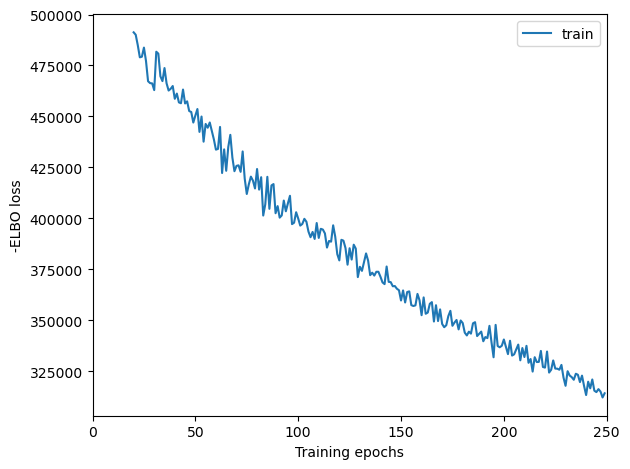

In [ ]:
RegMod.plot_history(20)
# plt.gcf().savefig(os.path.join(ref_results_dir,"reg_model_loss_plot.png"))
# plt.close()

In [ ]:
# Export estimated cell abundance - summary of posterior distribution
adata_ref_subset = RegMod.export_posterior(
    adata_ref_subset, sample_kwargs={"num_samples": 1000, "batch_size": 2500}
)

# Save model
RegMod.save(os.path.join(ref_results_dir, "reg_model"), overwrite=True)

# Save anndata object with results
adata_file = os.path.join(ref_results_dir, "sc_ref.h5ad")
adata_ref_subset.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:03<00:00, 265.47it/s]


... storing 'sample_cell_type' as categorical


'/home/agathes/work/data_analysis/results/cell_type_deconv/reference_signatures/sc_ref.h5ad'

In [ ]:
adata_ref_subset = RegMod.export_posterior(
    adata_ref_subset,
    use_quantiles=True,
    # choose quantiles
    add_to_varm=["q05", "q50", "q95", "q0001"],
    sample_kwargs={"batch_size": 2500},
)

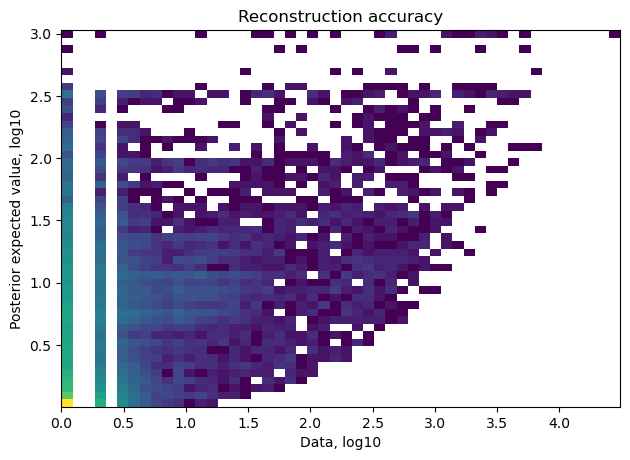

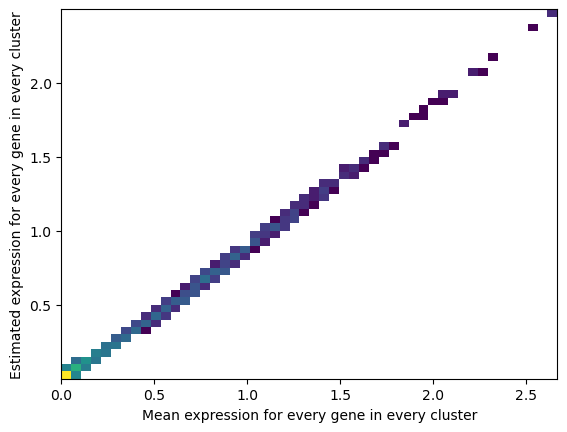

In [ ]:
RegMod.plot_QC(summary_name="q50")

In [ ]:
# # Load saved model and output h5ad
# adata_file = os.path.join(ref_results_dir,"sc_ref.h5ad")
# adata_ref = sc.read_h5ad(adata_file)
# RegMod = cell2location.models.RegressionModel.load(os.path.join(ref_results_dir,"reg_model"), adata_ref_subset)

In [ ]:
# export estimated expression in each cluster
if "means_per_cluster_mu_fg" in adata_ref_subset.varm.keys():
    inf_aver = adata_ref_subset.varm["means_per_cluster_mu_fg"][
        [
            f"means_per_cluster_mu_fg_{i}"
            for i in adata_ref_subset.uns["mod"]["factor_names"]
        ]
    ].copy()
else:
    inf_aver = adata_ref_subset.var[
        [
            f"means_per_cluster_mu_fg_{i}"
            for i in adata_ref_subset.uns["mod"]["factor_names"]
        ]
    ].copy()
inf_aver.columns = adata_ref_subset.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

,normal-B cell,normal-T cell,normal-endothelial cell,normal-epithelial cell,normal-fibroblast
gene_ids_2,,,,,
ENSG00000170310,0.000166,1.156561,0.088727,11.448052,23.899260
ENSG00000160888,0.000167,6.174341,8.499871,26.856415,9.984182
ENSG00000102466,0.000168,0.000167,0.000168,1.451787,4.266828
ENSG00000273289,0.000167,0.000166,0.000166,0.000167,0.000168
ENSG00000246985,0.000167,0.000167,0.000167,0.000168,0.000167


In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [ ]:
adata_vis_subset = adata_vis[:1000, :].copy()

In [ ]:
# prepare anndata for cell2location model
cell2loc.models.Cell2location.setup_anndata(adata=adata_vis_subset, batch_key="sample")

In [ ]:
# create and train the model
Cell2locMod = cell2loc.models.Cell2location(
    adata_vis_subset,
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20,
)
Cell2locMod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1000  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │  181  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  18P06762  │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
Cell2locMod.train(
    max_epochs=300,
    # train using full data (batch_size=None)
    batch_size=None,
    # use all data points in training because
    # we need to estimate cell abundance at all locations
    train_size=1,
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
Cell2locMod.plot_history(100)
plt.legend(labels=["full data training"])
plt.gcf().savefig(os.path.join(map_results_dir, f"cell2loc_mod_loss_train_{slide}.png"))
plt.close()

INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 300/300: 100%|██████████| 300/300 [00:10<00:00, 29.27it/s, v_num=1, elbo_train=3.92e+5]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [00:10<00:00, 29.64it/s, v_num=1, elbo_train=3.92e+5]


In [ ]:
# Export the estimated cell abundance (summary of the posterior distribution).
adata_vis = Cell2locMod.export_posterior(
    adata_vis_subset,
    sample_kwargs={"num_samples": 1000, "batch_size": Cell2locMod.adata.n_obs},
)

# Save model
Cell2locMod.save(os.path.join(map_results_dir, "cell2loc_mod"), overwrite=True)

# Save anndata object with results
adata_file = os.path.join(map_results_dir, "st_map.h5ad")
adata_vis_subset.write(adata_file)
adata_file

# # Load saved model and output h5ad
# adata_file = os.path.join(ref_results_dir,"st_map.h5ad")
# adata_vis = sc.read_h5ad(adata_file)
# Cell2locMod = cell2location.models.Cell2location.load(os.path.join(map_results_dir, "cell2loc_mod"), adata_vis)

Sampling global variables, sample: 100%|██████████| 999/999 [00:06<00:00, 161.53it/s]


'/home/agathes/work/data_analysis/results/cell_type_deconv/18P06762/cell2location_map/st_map.h5ad'

In [ ]:
Cell2locMod.plot_QC()
plt.gcf().savefig(os.path.join(map_results_dir, f"cell2loc_mod_qc_{slide}.png"))
plt.close()

In [ ]:
fig = (
    Cell2locMod.plot_spatial_QC_across_batches()
)  # to compare mutliple samples/natchs.
# Here models are trained for one sample. Comparison can not really be done as models do not learn accross samples.
# It is ok to run function for only one sample
plt.gcf().savefig(os.path.join(map_results_dir, f"cell2loc_mod_qc_mapped_{slide}.png"))
plt.close()

In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis_subset.obs[adata_vis_subset.uns["mod"]["factor_names"]] = (
    adata_vis_subset.obsm["q05_cell_abundance_w_sf"]
)

# plot in spatial coordinates
with mpl.rc_context({"axes.facecolor": "black", "figure.figsize": [4.5, 5]}):

    sc.pl.spatial(
        adata_vis_subset,
        cmap="magma",
        # show first 8 cell types
        color=[
            "normal-T cell",
            "normal-epithelial cell",
            "normal-fibroblast",
            "tumor-T cell",
            "tumor-epithelial cell",
            "tumor-fibroblast",
            "tumor-malignant cell",
        ],
        ncols=4,
        size=1.3,
        img_key="hires",
        # limit color scale at 99.2% quantile of cell abundance
        vmin=0,
        vmax="p99.2",
        show=False,
    )
    plt.gcf().savefig(os.path.join(map_results_dir, f"cell_abundance_{slide}.png"))
    plt.close()

In [ ]:
# up to 6 clusters
clust_labels = [
    "normal-T cell",
    "normal-fibroblast",
    "tumor-T cell",
    "tumor-fibroblast",
    "tumor-malignant cell",
]
clust_col = [
    "" + str(i) for i in clust_labels
]  # in case column names differ from labels

with mpl.rc_context({"figure.figsize": (15, 15)}):
    fig = plot_spatial(
        adata=adata_vis_subset,
        # labels to show on a plot
        color=clust_col,
        labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style="fast",
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.792,
        # size of locations (adjust depending on figure size)
        circle_diameter=7,
        colorbar_position="right",
    )
    plt.gcf().savefig(
        os.path.join(map_results_dir, f"cell_abundance_multiple_{slide}.png")
    )
    plt.close()

In [ ]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis_subset, use_rep="q05_cell_abundance_w_sf", n_neighbors=15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis_subset, resolution=1.1)

# add region as categorical variable
adata_vis_subset.obs["region_cluster"] = adata_vis_subset.obs["leiden"].astype(
    "category"
)

In [ ]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis_subset, min_dist=0.3, spread=1)

# show regions in UMAP coordinates
with mpl.rc_context({"axes.facecolor": "white", "figure.figsize": [8, 8]}):
    sc.pl.umap(
        adata_vis_subset,
        color=["region_cluster"],
        size=30,
        color_map="RdPu",
        ncols=2,
        legend_loc="on data",
        legend_fontsize=20,
        show=False,
    )
    plt.gcf().savefig(
        os.path.join(map_results_dir, f"umap_cell_abundance_{slide}.png"),
        bbox_inches="tight",
    )
    plt.close()

# plot in spatial coordinates
with mpl.rc_context({"axes.facecolor": "black", "figure.figsize": [4.5, 5]}):
    sc.pl.spatial(
        adata_vis_subset,
        color=["region_cluster"],
        size=1.3,
        img_key="hires",
        alpha=0.5,
        show=False,
    )
    plt.gcf().savefig(
        os.path.join(map_results_dir, f"umal_cluster cell_abundance_{slide}.png"),
        bbox_inches="tight",
    )
    plt.close()

In [ ]:
# with np.errstate(invalid="ignore", divide="ignore"), warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=FutureWarning)
#     res_dict, adata_vis = cell2loc.run_colocation(
#         adata_vis_subset,
#         model_name="CoLocatedGroupsSklearnNMF",
#         train_args={
#             "n_fact": np.arange(
#                 5, 31, 5
#             ),  # IMPORTANT: use a wider range of the number of factors (5-30)
#             "sample_name_col": "sample",  # columns in adata_vis.obs that identifies sample
#             "n_restarts": 3,  # number of training restarts
#         },
#         # the hyperparameters of NMF can be also adjusted:
#         model_kwargs={
#             "alpha": 0.01,
#             "init": "random",
#             "nmf_kwd_args": {"tol": 0.000001},
#         },
#         export_args={"path": f"{map_results_dir}/CoLocatedComb/"},
# )